In [2]:
# -*- coding: utf-8 -*- 
from sklearn.metrics import accuracy_score, precision_score,recall_score, confusion_matrix, roc_auc_score, classification_report, f1_score,make_scorer
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.decomposition import PCA
#from sklearn_evaluation import plot
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier, plot_importance
#from lightgbm import LGBMClassifier,plot_importance
from IPython.core.interactiveshell import InteractiveShell
from imblearn.over_sampling import SMOTE
from sklearn.metrics import make_scorer
from sklearn import metrics
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
#from xgboost import plot_importance
import pickle
InteractiveShell.ast_node_interactivity = 'all'
warnings.filterwarnings(action='ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.float_format = '{:.5f}'.format

In [85]:
def preprocessing_data(file):
    data=pd.read_csv(file)
    df=pd.DataFrame(data)
    
    ###[setup]
    # [wther]
    if 'train' in file:
        def fill_hmdt(df):
            ls_=[95,96,97,30,72,92,16,100,78,98,97,80,85,85,100,95,50,40,65,25,60,60]
            i=0
            for k in df.loc[df.hmdt.isnull()==1,:].index:
                df.loc[k,'hmdt']=ls_[i]
                i+=1
        def fill_wnd_spd(df):
            df['emd']=df['emd_nm'].apply(lambda x: str(x)).apply(lambda x: x[5:8])
            df['month']=df['dt_of_fr'].apply(lambda x: x.split('-')[1])
            df['time']=df['dt_of_fr'].apply(lambda x: x.split('-')[2])
            df['time']=df['time'].apply(lambda x: x[3:5]).apply(lambda x: int(x))

            for i in df.loc[df.wnd_spd.isnull()==1,:].index:
                m=df.loc[i,'month']
                t=df.loc[i,'time']
                e=df.loc[i,'emd']
                df.loc[i,'wnd_spd']=df.loc[(df.month==m)&(df.time==t)&(df.emd==e),'wnd_spd'].mean()
        fill_hmdt(df)
        fill_wnd_spd(df)
    else:
        def fill_hmdt(df):
            ls_=[]
            ls_.append((90+90+85)/3)
            ls_.append((47+58+44)/3)
            ls_.append((90+90+85)/3)
            i=0
            for k in df.loc[df.hmdt.isnull()==1,:].index:
                df.loc[k,'hmdt']=ls_[i]
                i+=1
        def fill_wnd_spd(df):
            df_=df
            df_['month']=df['dt_of_fr'].apply(lambda x: x.split('-')[1])
            df_['time']=df['dt_of_fr'].apply(lambda x: x.split('-')[2])
            df_['time']=df_['time'].apply(lambda x: x[3:5]).apply(lambda x: int(x))

            for i in df.loc[df.wnd_spd.isnull()==1,:].index:
                    m=df_.loc[i,'month']
                    t=df_.loc[i,'time']
                    df.loc[i,'wnd_spd']=df_.loc[(df_.month==m)&(df_.time==t),'wnd_spd'].mean()
        fill_hmdt(df)
        fill_wnd_spd(df)
    
    # dt_of_fr_month(월), dt_of_fr_day(일), dt_of_fr_hour(시간)
    df['dt_of_fr']=pd.to_datetime(df['dt_of_fr'])

    df['dt_of_fr_month']=df['dt_of_fr'].dt.month
    df['dt_of_fr_day']=df['dt_of_fr'].dt.day
    df['dt_of_fr_hour']=df['dt_of_fr'].dt.hour

    # wnd_dr8 풍향(ex-북과 동 사이는 모두 북동)
    def dr8(x):
        if ((x>360-22.5) & (x<=0+22.5)) | ((x==0)|(x==360)):
            return 'N'
        elif (x>45-22.5) & (x<=45+22.5):
            return 'NE'
        elif (x>90-22.5) & (x<=90+22.5):
            return 'E'
        elif (x>135-22.5) & (x<=135+22.5):
            return 'SE'
        elif (x>180-22.5) & (x<=180+22.5):
            return 'S'
        elif (x>225-22.5) & (x<=225+22.5):
            return 'SW'
        elif (x>270-22.5) & (x<=270+22.5):
            return 'W'
        else:
            return 'NW'

    df['wnd_dr8']=df['wnd_drctn'].apply(dr8)
    # [wther]
    
#     # [bldng]
#     df.loc[12642,'dt_of_athrztn']=19800808
#     df.loc[21218,'dt_of_athrztn']=19900712
#     df.loc[26351,'dt_of_athrztn']=19990624
#     df.loc[30954,'dt_of_athrztn']=19820930
#     df.loc[38448,'dt_of_athrztn']=19780421
#     df.loc[53193,'dt_of_athrztn']=19971215

#     # yr_of_athrztn(건물승인년도)
#     df['yr_of_athrztn']=df['dt_of_athrztn'].apply(lambda x: str(x)[0:4] if pd.isna(x)==False else x)

#     # bldng_yrs (건물연수)
#     df['bldng_yrs']=df['yr_of_athrztn'].apply(lambda x: 2019-int(x) if pd.isna(x)==False else x)
    
#     # floors(건물 총 층수)
#     df['floors']=df['ttl_grnd_flr']+df['ttl_dwn_flr']
    # [bldng]
    
    # fr_yn(화재발생) -> 1,0
    dict={"Y":1,"N":0}
    df.fr_yn=df.fr_yn.map(dict)
    ###[setup]
    
    
    ### [fill null and cut]
    # tmprtr
    n=df.loc[df['tmprtr'].isnull(),['tmprtr','emd_nm','dt_of_fr_month','dt_of_fr_hour']]

    def fill_tmprtr(row):
        return df.loc[(df['emd_nm']==row[1]) & (df['dt_of_fr_month']==row[2]) & (df['dt_of_fr_hour']==row[3]),'tmprtr'].mean()

    def fill_tmprtr2(row):
        return df.loc[(df['emd_nm']==row[1]) & (df['dt_of_fr_month']==row[2]) & ((df['dt_of_fr_hour']==row[3]+1) | (df['dt_of_fr_hour']==row[3]-1)),'tmprtr'].mean()

    n['tmprtr']=n.apply(fill_tmprtr,axis=1)
    n.loc[n['tmprtr'].isnull(),'tmprtr']=n.loc[n['tmprtr'].isnull()].apply(fill_tmprtr2, axis=1)
    
    tmp_null_ind=list(n.index)
    df.loc[tmp_null_ind,'tmprtr']=n['tmprtr']
    
    # bldng
    df_cut=df.loc[(df['bldng_ar']<=155.1*2)&(df['bldng_ar']!=0)&(df['ttl_ar']!=0)&(df['bldng_cnt']<=4*2),:]
    def bldcnt3(x):
        if x==1:
            return 0
        elif (x==2) | (x==3):
            return 1
        elif x>=4:
            return 2
    df_cut['bldng_cnt_3']=df_cut['bldng_cnt'].apply(bldcnt3)
    
    # drop1(not using)
    cols=[i for i in df_cut.columns if ('lw_' not in i)&('gas' not in i)&('ele' not in i)]
    df2=df_cut.loc[:,cols]
    dropcol=['bldng_us','bldng_archtctr','lnd_ar','dt_of_athrztn','ttl_grnd_flr','ttl_dwn_flr','bldng_us_clssfctn',
    'prcpttn','id',
    'trgt_crtr','fr_fghtng_fclt_spcl_css_5_yn','fr_fghtng_fclt_spcl_css_6_yn','us_yn','dngrs_thng_yn', 
    'slf_fr_brgd_yn','blk_dngrs_thng_mnfctr_yn','cltrl_hrtg_yn']

    df2.drop(dropcol,axis=1,inplace=True)
    
    ### [Feature Engineering]
    # drop null
    df2.dropna(subset=['rgnl_ar_nm','lnd_us_sttn_nm','rd_sd_nm','emd_nm','fr_mn_cnt'],inplace=True)

    # admin cols
    def rg1cat(x):
        if x in ['자연녹지지역', '자연환경보전지역', '보전관리지역', '개발제한구역', '보전녹지지역', '용도미지정', '생산녹지지역', '농림지역']:
            return 0
        elif x in ['계획관리지역', '관리지역']:
            return 1
        elif x in ['제1종일반주거지역', '제1종전용주거지역', '제2종전용주거지역', '제2종일반주거지역', '제3종일반주거지역', '준주거지역']:
            return 2
        elif x in ['일반상업지역','생산관리지역','근린상업지역', '유통상업지역', '중심상업지역']:
            return 3
        elif x in ['일반공업지역', '준공업지역']:
            return 4
        
    df2['rgnl_ar_nm_cat']=df2['rgnl_ar_nm'].apply(rg1cat)
    
    def jmkcat(x):
        if x in ['차', '체', '장', '사']:
            return 0
        elif x in ['양', '학', '주', '잡', '철', '원']:
            return 1
        elif x in ['창','종','목', '공', '제','유']:
            return 2
        elif x in ['답', '전','임','도','묘','과','구','천','수']:
            return 3
        elif x in ['대']:
            return 4
        
    df2['jmk_cat']=df2['jmk'].apply(jmkcat)
    
    def lndus(x):
        if x in ['고속도로휴게소', '여객자동차터미널', '주차장등', '유해.혐오시설','위험시설']:
            return 0
        elif x in ['아파트']:
            return 1
        elif x in ['단독', '연립', '주거기타', '주거나지', '주상용', '주상나지', '주상기타', '다세대']:
            return 2
        elif x in ['자연림','답', '전기타', '전', '조림', '답기타', '과수원', '토지임야', '임야기타', '공원등','하천등','목장용지']:
            return 3
        elif x in ['상업기타','상업나지','상업용','업무용', '공업용','공업기타', '상업기타','공업나지']:
            return 4
        elif x in ['유원지', '스키장', '콘도미니엄', '기타', '특수기타','발전소','도로등','골프장 회원제', '골프장 대중제', '공원묘지','운동장등']:
            return 5
        
    df2['lnd_us_sttn_nm_cat']=df2['lnd_us_sttn_nm'].apply(lndus)
    
    def rdnm(x):
        if x in ['세로한면(불)', '세로한면(가)']:
            return 0
        elif x in ['소로각지', '세로각지', '중로한면', '소로한면','중로각지']:
            return 1
        elif x in ['세로각지(가)', '세로각지(불)']:
            return 2
        elif x in ['광대세각', '광대로한면', '지정되지않음', '광대소각', '맹지']:
            return 3
        
    df2['rd_sd_nm_cat']=df2['rd_sd_nm'].apply(rdnm)
#     df2['emd_nm_ct']=df2['emd_nm'].apply(lambda x: str(x)[5:7])

#     eng_name_dict={'거제':'geojesi', '거창':'geochanggun', '고성':'goseonggun', '남해':'namhaegun', '밀양':'miryangsi', '사천':'sacheonsi', '산청':'sancheonggun', '양산':'yangsan', '의령':'uiryeonggun', '진주':'jinjusi', '창녕':'changnyeonggun', '창원':'changwonsi', '통영':'tongyeongsi', '하동':'hadonggun','함안':'hamangun', '함양':'hamyanggun','합천':'hapcheongun'}
#     df2['emd_nm_ct']=df2['emd_nm_ct'].map(eng_name_dict)
    df2['mlt_us_yn_num']=df2['mlt_us_yn'].map({'Y':1,'N':0})
    
    # environment cols
    def slice(st,q1,q2,q3,x):
        if((x>=st) & (x<q1)):
            return 1
        elif((x>=q1) &(x<q2)):
            return 2
        elif((x>=q2)& (x<q3)):
            return 3
        else:
            return 4
    df2["fr_wthr_fclt_dstnc_sl"]=df2['fr_wthr_fclt_dstnc'].apply(lambda x:slice(0,114,643,2494,x))
    df2["cctv_dstnc_sl"]=df2['cctv_dstnc'].apply(lambda x:slice(0,100,288,889,x))
    df2["tbc_rtl_str_dstnc_sl"]=df2['tbc_rtl_str_dstnc'].apply(lambda x:slice(0,527,2184,4958,x))
    df2["ahsm_dstnc_sl"]=df2['ahsm_dstnc'].apply(lambda x:slice(0,761,3210,14239,x))
    df2["no_tbc_zn_dstnc_sl"]=df2['no_tbc_zn_dstnc'].apply(lambda x:slice(0,155,422,1486,x))
    ###[fill null and cut]
    
    ###[create X, y]
    using=['bldng_cnt_3','bldng_ar','ttl_ar','tmprtr', 'wnd_spd', 'hmdt', 'wnd_dr8',
           'rgnl_ar_nm_cat', 'jmk_cat', 'lnd_us_sttn_nm_cat', 'rd_sd_nm_cat', 'emd_nm_ct','fr_sttn_dstnc',
          'fr_wthr_fclt_dstnc_sl','fr_mn_cnt', 'mlt_us_yn_num','cctv_dstnc_sl', 'tbc_rtl_str_dstnc_sl', 'ahsm_dstnc_sl', 'no_tbc_zn_dstnc_sl','sft_emrgnc_bll_dstnc',
           'fr_yn']

    df_use=df2.loc[:,using]

    ohe_wnd = pd.get_dummies(df_use['wnd_dr8']) 
    df_use=pd.concat([df_use, ohe_wnd], axis=1) 
    del df_use['wnd_dr8'] 

    ohe_emd = pd.get_dummies(df_use['emd_nm_ct'])
    df_final=pd.concat([df_use, ohe_emd], axis=1) 
    del df_final['emd_nm_ct'] 


    X=df_final.drop(['fr_yn'],axis=1)
    y=df_final['fr_yn']
    ###[create X, y]
    
    if 'train' in file:
        smote=SMOTE(random_state=0)
        X_over,y_over=smote.fit_sample(X,y)
        return X_over, y_over
    else:
        return X, y

In [86]:
X_train, y_train=preprocessing_data('PJT002_train.csv')
X_test, y_test=preprocessing_data('PJT002_validation.csv')

In [70]:
print(X_train.shape, y_train.shape,X_test.shape,y_test.shape)

(70956, 27) (70956,) (7704, 27) (7704,)


In [71]:
def get_clf_eval(y_test,y_pred):
    plt.figure(figsize=(16,6))
    accuracy=accuracy_score(y_test,y_pred)
    precision=precision_score(y_test,y_pred)
    recall=recall_score(y_test,y_pred)
    f1 = f1_score(y_test, y_pred)
#     print(classification_report(y_test, y_pred)
    print('정확도: {0:.4f} 정밀도: {1:.4f} 재현율: {2:,.4f} f1 : {3:.3f}'.format(accuracy, precision, recall, f1))
    print(classification_report(y_test, y_pred))
def get_model_train_eval(model,i):
    model.fit(X_train,y_train)
    #modeling 함수 for문으로
    y_proba=model.predict_proba(X_test) 
    y_pred=model.predict(X_test)
    return y_proba

def determine_y(x,threshold):
    if x>=threshold:
        return 1
    else:
        return 0
def predy(x,threshold):
    y_list=[]
    for i in x:
        y_list.append(determine_y(i,threshold))
    return y_list

In [72]:
metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [73]:
xgb_clf=XGBClassifier(objective='binary:logistic')

#X_train, X_test, y_train, y_test = train_test_split(X_list[i], Y_list[i],test_size = 0.2)
evals = [(X_test, y_test)]
estimator = xgb_clf
parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
 }

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'f1',
    n_jobs = 10,
    cv = 3,
    verbose=True
)

grid_search.fit(X_test, y_test)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    8.6s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  1.5min
[Parallel(n_jobs=10)]: Done 288 out of 288 | elapsed:  2.6min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=10,
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': range(2, 10),
                         'n_estimators': range(60, 220, 

In [74]:
grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 100}

In [75]:
grid_search.best_score_

0.9147595667548702

<Figure size 2160x1440 with 0 Axes>

<Figure size 2160x1440 with 0 Axes>

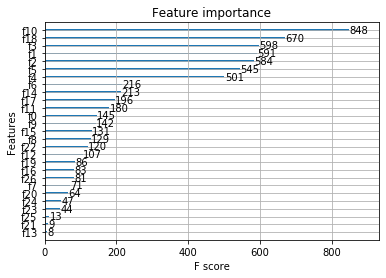

In [76]:
plt.figure(figsize=(30,20))
plot_importance(grid_search.best_estimator_)

In [89]:
print(X_test.columns[10])
print(X_test.columns[18])
print(X_test.columns[3])
print(X_test.columns[1])
print(X_test.columns[2])
print(X_test.columns[5])
print(X_test.columns[4])
print(X_test.columns[6])
print(X_test.columns[14])

fr_sttn_dstnc
sft_emrgnc_bll_dstnc
tmprtr
bldng_ar
ttl_ar
hmdt
wnd_spd
rgnl_ar_nm_cat
cctv_dstnc_sl


In [78]:
proba = grid_search.best_estimator_.predict_proba(X_test)
pred = predy(proba[:,1],0.5)
get_clf_eval(y_test,pred)

정확도: 0.9856 정밀도: 1.0000 재현율: 0.9712 f1 : 0.985
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      3852
           1       1.00      0.97      0.99      3852

    accuracy                           0.99      7704
   macro avg       0.99      0.99      0.99      7704
weighted avg       0.99      0.99      0.99      7704



<Figure size 1152x432 with 0 Axes>

In [42]:
filename_list ='model_1.sav'
pickle.dump(grid_search.best_estimator_, open(filename_list, 'wb'))

In [0]:
logst_clf=LogisticRegression(penalty='l2')
a = get_model_train_eval(logst_clf,0.5)
proba_y = pd.Series(a[:,1])
pred = proba_y.apply(lambda x: predy(x,0.5))
get_clf_eval(y_test,pred)

dt_clf = DecisionTreeClassifier()
rf_clf = RandomForestClassifier(n_estimators=100, n_jobs = -1)
lgbm_clf=LGBMClassifier(n_estimators=1000,num_leaves=64,n_jobs=-1,boost_from_average=False)

print('########## LogisticReg ##########')
get_model_train_eval(logst_clf)
print('########## DecisionTree ##########')
get_model_train_eval(dt_clf)
print('########## RandomForest ##########')
get_model_train_eval(rf_clf)
# print('########## xgboost_clf ##########')
# get_model_train_eval(xgb_clf)
print('########## lgbm_clf ##########')
get_model_train_eval(lgbm_clf)

plt.show()

In [0]:
cross_val_score(lgbm_clf, X_over, y_over, cv=10)

In [0]:
plt.figure(figsize=(30,20))
plot.feature_importances(lgbm_clf,feature_names=list(X.columns))